## data generator

In [2]:
import cupy as cp
from tqdm import tqdm

In [58]:
image_size = 8
seq_length = 128
cp.random.seed(66)

# 定义一个简单的高斯核函数
def kernel(h1, h2,v=2):
    return cp.exp(-(((h1 - h2) ** 2)**(v/2) / (2 * l_)))

def sigma_matrix():
    # 生成一个8x8的随机矩阵
    random_matrix = cp.random.randn(8, 8, dtype=cp.float64)
    return random_matrix @ random_matrix.T  # 使用@符号进行矩阵乘法

def kernel_matrix():
    # 创建一个128x128的核矩阵
    K = cp.zeros((seq_length, seq_length), dtype=cp.float64)
    for i in range(seq_length):
        for j in range(seq_length):
            K[i, j] = kernel(i, j)
    return K

def cov_matrix():
    # 计算核矩阵和随机噪声矩阵的Kronecker积
    epsilon=1e-8
    sigm = cp.load("cpseed66.npy")
    matrix=cp.kron(kernel_matrix(), sigm)
    #print(sigm)

    res = matrix + epsilon*cp.eye(image_size*seq_length)
    # print(res)
    return res

def generate_videos(num):
    mean = cp.zeros(image_size * seq_length, dtype=cp.float64)
    cov = cov_matrix()
    videos = []
    for i in tqdm(range(num)):
        # 生成视频数据，并重塑为所需的形状
        video = cp.random.multivariate_normal(mean, cov).reshape((seq_length, image_size))
        # print(video)
        videos.append(cp.asnumpy(video))  # 转换为numpy数组以保存
    return videos  # 返回视频列表
v=2
l_list=[4,16,64,256,1024]
n_list=[10000]
N_list=[128]
l_=512
for seq_length in N_list:
    for num_videos in n_list:
        for repeat in range(5):
            videos = generate_videos(num_videos)
            cp.save(f"./video_data/data_videos_n={num_videos}_v={v}_l={l_}_N={seq_length}_r={repeat}.npy", cp.array(videos))

  0%|          | 0/10000 [00:00<?, ?it/s]/bicmr/home/hengyuf04/.conda/envs/BnBcard/lib/python3.10/site-packages/cupy/random/_distributions.py:476: FutureWarning: cupy.random.multivariate_normal is experimental. The interface can change in the future.
  _util.experimental('cupy.random.multivariate_normal')
/bicmr/home/hengyuf04/.conda/envs/BnBcard/lib/python3.10/site-packages/cupy/random/_generator.py:337: FutureWarning: cupy.random.RandomState.multivariate_normal is experimental. The interface can change in the future.
  _util.experimental('cupy.random.RandomState.multivariate_normal')
100%|██████████| 10000/10000 [00:19<00:00, 501.52it/s]


In [ ]:
import shutil

shutil.copy('./data_videos_100000.npy','./drive/My Drive/')

In [11]:
import numpy as np

# 加载.npy文件
data = np.load('data_videos_100000.npy')

# 检查是否存在NaN值
if np.isnan(data).any():
    print("存在NaN值。")
else:
    print("没有NaN值。")


没有NaN值。


In [ ]:
!git clone https://github.com/facebookresearch/DiT.git

Cloning into 'DiT'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 102 (delta 55), reused 35 (delta 35), pack-reused 23
Receiving objects: 100% (102/102), 6.37 MiB | 37.26 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
!ls

bin   dev	guojiawei1  lib64  models  root  srv   tmp
boot  etc	home	    media  opt	   run	 sys   usr
data  examples	lib	    mnt    proc    sbin  tini  var


In [ ]:
!python /content/DiT/sample.py --image-size 512 --seed 1

Traceback (most recent call last):
  File "/content/DiT/sample.py", line 15, in <module>
    from diffusers.models import AutoencoderKL
ModuleNotFoundError: No module named 'diffusers'


## warm up

In [ ]:
import shutil

shutil.copy('./drive/My Drive/data_videos_100000.npy','./')

In [ ]:
!pip install timm
!pip install diffusers
!pip install accelerate

## models

In [5]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# GLIDE: https://github.com/openai/glide-text2im
# MAE: https://github.com/facebookresearch/mae/blob/main/models_mae.py
# --------------------------------------------------------

import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp


def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


#################################################################################
#               Embedding Layers for Timesteps and Class Labels                 #
#################################################################################

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
            # print('drop',drop_ids)
        else:
            drop_ids = force_drop_ids == 1
        # print('drop2',labels)
        labels = torch.where(drop_ids, self.num_classes, labels)
        # print('drop3',labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings


#################################################################################
#                                 Core DiT Model                                #
#################################################################################

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x


class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        ##### self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.linear = nn.Linear(hidden_size, patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

class TemporalPatchEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(TemporalPatchEmbedding, self).__init__()
        self.linear = nn.Linear(input_size, hidden_size, bias=bias)

    def forward(self, x):
        # 输入 x 的形状：[batch_size, seq_len, input_size]

        # 将输入 x 变形为 [batch_size * seq_len, input_size]
        N,T,D=x.shape
        x = x.view(-1, D)
        # print('a',x.shape)
        # 应用 Linear 层
        x = self.linear(x)
        # print('b',x.shape)
        # 将结果变形回原来的形状 [batch_size, seq_len, hidden_size]
        x = x.view(N, T, x.shape[-1])
        # print('c',x.shape)
        return x


class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1000,
        learn_sigma=True,
        seq_length=128,
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = 1
        self.out_channels = self.in_channels * 2 if learn_sigma else self.in_channels
        # print('out',self.out_channels)
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        

        # self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        
        #Test
        self.x_embedder = TemporalPatchEmbedding(input_size, hidden_size//2, bias=True)    
        self.t_embedder = TimestepEmbedder(hidden_size)
        
        
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        self.num_patches = seq_length ## [N,T,D] no T
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches,self.hidden_size//2), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_1d_sincos_pos_embed(self.num_patches,self.hidden_size//2)
        # pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        # w = self.x_embedder.proj.weight.data
        # nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        # nn.init.constant_(self.x_embedder.proj.bias, 0)
        w = self.x_embedder.linear.weight.data
        b = self.x_embedder.linear.bias.data
        nn.init.xavier_uniform_(w)
        nn.init.constant_(b, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        # print('unp',x.shape)
        p = self.num_patches

        # B, T, C = x.shape

        # x = x.reshape(shape=(x.shape[0], p, p))
        # x = torch.einsum('nhwpqc->nchpwq', x)
        # imgs = x.reshape(shape=(B, C, T))
        # return imgs
        return x

    def forward(self, x, t, y):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        # print('f1',x.shape)
        #print(self.x_embedder(x).shape,self.pos_embed.shape)
        x_embed=self.x_embedder(x)
        #print(x_embed.shape,self.pos_embed.shape)
        
        x = torch.cat([x_embed,self.pos_embed.expand(x_embed.shape[0],-1,-1)],dim=-1) 
        
        
        # (N, T, D), where T = H * W / patch_size ** 2
        # print('f2',x.shape)
        t = self.t_embedder(t)                   # (N, D)
        # print('f3',t.shape)
        y = self.y_embedder(y, self.training)    # (N, D)
        # print('f4',y.shape)
        c = t + y                                # (N, D)
        # print('f5',torch.abs(x[0]).mean())
        for (i,block) in enumerate(self.blocks):
            x = block(x, c)                      # (N, T, D)
            # print(f'f6_{i}',torch.abs(x[0]).mean())
        # print('f6',x.shape)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        # print('f7',x.shape)
        # print('f7',torch.abs(x[0]).mean())
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        # print('f8',x.shape)
        # print('f8',torch.abs(x[0]).mean())
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        # print('0000',model_out.shape)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :, :self.patch_size], model_out[:, :,self.patch_size:]
        # print('1111',eps.shape,rest.shape)
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        # print('2222',cond_eps.shape,uncond_eps.shape)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        # print('3333',half_eps.shape)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=2)


#################################################################################
#                   Sine/Cosine Positional Embedding Functions                  #
#################################################################################
# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_1d_sincos_pos_embed(seq_length, hidden_size):
    """
    seq_length: 长度为 seq_length 的序列
    hidden_size: 每个时间点的向量维度
    return:
    pos_embed: 位置编码矩阵，形状为 [seq_length, hidden_size]
    """
    assert hidden_size % 2 == 0, "hidden_size must be even for sin-cos encoding"
    omega = np.arange(hidden_size // 2, dtype=np.float64)
    omega /= hidden_size / 2.
    omega = 1. / 10000 ** omega  # (D/2,)

    pos = np.arange(seq_length, dtype=np.float64)  # 时间步数作为位置编码的维度
    out = np.einsum('m,d->md', pos, omega)  # (seq_length, D/2), outer product

    emb_sin = np.sin(out)  # (seq_length, D/2)
    emb_cos = np.cos(out)  # (seq_length, D/2)

    pos_embed = np.concatenate([emb_sin, emb_cos], axis=1)  # (seq_length, D)
    return pos_embed



#################################################################################
#                                   DiT Configs                                  #
#################################################################################

def DiT_XL_2(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=2, num_heads=16, **kwargs)

def DiT_XL_4(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=4, num_heads=16, **kwargs)

def DiT_XL_8(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=8, num_heads=16, **kwargs)

def DiT_L_2(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=2, num_heads=16, **kwargs)

def DiT_L_4(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=4, num_heads=16, **kwargs)

def DiT_L_8(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=8, num_heads=16, **kwargs)

def DiT_B_2(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=2, num_heads=12, **kwargs)

def DiT_B_4(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=4, num_heads=12, **kwargs)

def DiT_B_8(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=8, num_heads=12, **kwargs)

def DiT_S_2(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=2, num_heads=6, **kwargs)

def DiT_S_4(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=4, num_heads=6, **kwargs)

def DiT_S_8(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=8, num_heads=6, **kwargs)

def DiT_P_8(**kwargs):
    return DiT(depth=12, hidden_size=32, patch_size=8, num_heads=16, **kwargs)


def DiT_PD_8_N32(**kwargs):
    return DiT(depth=12, hidden_size=32, patch_size=8, num_heads=4, seq_length=32, **kwargs)

def DiT_PD_8_N32(**kwargs):
    return DiT(depth=12, hidden_size=16, patch_size=8, num_heads=4, seq_length=32, **kwargs)

def DiT_PD_8_N128(**kwargs):
    return DiT(depth=12, hidden_size=32, patch_size=8, num_heads=4, seq_length=128, **kwargs)

def DiT_PD_8_N512(**kwargs):
    return DiT(depth=12, hidden_size=32, patch_size=8, num_heads=4, seq_length=512, **kwargs)



DiT_models = {
    'DiT-XL/2': DiT_XL_2,  'DiT-XL/4': DiT_XL_4,  'DiT-XL/8': DiT_XL_8,
    'DiT-L/2':  DiT_L_2,   'DiT-L/4':  DiT_L_4,   'DiT-L/8':  DiT_L_8,
    'DiT-B/2':  DiT_B_2,   'DiT-B/4':  DiT_B_4,   'DiT-B/8':  DiT_B_8,
    'DiT-S/2':  DiT_S_2,   'DiT-S/4':  DiT_S_4,   'DiT-S/8':  DiT_S_8,
    'DiT-P/8':  DiT_P_8,   'DiT-PD/8_N=32':  DiT_PD_8_N32, 'DiT-PD/8_N=128':  DiT_PD_8_N128, 'DiT-PD/8_N=512':  DiT_PD_8_N512
}


## Diffusion

In [11]:

##################################################################3
      #  diffusion utils
##################################################################3

# Modified from OpenAI's diffusion repos
#     GLIDE: https://github.com/openai/glide-text2im/blob/main/glide_text2im/gaussian_diffusion.py
#     ADM:   https://github.com/openai/guided-diffusion/blob/main/guided_diffusion
#     IDDPM: https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py

import torch as th
import numpy as np


def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    Compute the KL divergence between two gaussians.
    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, th.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for th.exp().
    logvar1, logvar2 = [
        x if isinstance(x, th.Tensor) else th.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + th.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * th.exp(-logvar2)
    )


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + th.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * th.pow(x, 3))))


def continuous_gaussian_log_likelihood(x, *, means, log_scales):
    """
    Compute the log-likelihood of a continuous Gaussian distribution.
    :param x: the targets
    :param means: the Gaussian mean Tensor.
    :param log_scales: the Gaussian log stddev Tensor.
    :return: a tensor like x of log probabilities (in nats).
    """
    centered_x = x - means
    inv_stdv = th.exp(-log_scales)
    normalized_x = centered_x * inv_stdv
    log_probs = th.distributions.Normal(th.zeros_like(x), th.ones_like(x)).log_prob(normalized_x)
    return log_probs


def discretized_gaussian_log_likelihood(x, *, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image.
    :param x: the target images. It is assumed that this was uint8 values,
              rescaled to the range [-1, 1].
    :param means: the Gaussian mean Tensor.
    :param log_scales: the Gaussian log stddev Tensor.
    :return: a tensor like x of log probabilities (in nats).
    """
    assert x.shape == means.shape == log_scales.shape
    centered_x = x - means
    inv_stdv = th.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = th.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = th.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = th.where(
        x < -0.999,
        log_cdf_plus,
        th.where(x > 0.999, log_one_minus_cdf_min, th.log(cdf_delta.clamp(min=1e-12))),
    )
    assert log_probs.shape == x.shape
    return log_probs


##################################################################3
      #  Gaussian Diffusion
##################################################################3

# Modified from OpenAI's diffusion repos
#     GLIDE: https://github.com/openai/glide-text2im/blob/main/glide_text2im/gaussian_diffusion.py
#     ADM:   https://github.com/openai/guided-diffusion/blob/main/guided_diffusion
#     IDDPM: https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py


import math

import numpy as np
import torch as th
import enum



def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


class ModelMeanType(enum.Enum):
    """
    Which type of output the model predicts.
    """

    PREVIOUS_X = enum.auto()  # the model predicts x_{t-1}
    START_X = enum.auto()  # the model predicts x_0
    EPSILON = enum.auto()  # the model predicts epsilon


class ModelVarType(enum.Enum):
    """
    What is used as the model's output variance.
    The LEARNED_RANGE option has been added to allow the model to predict
    values between FIXED_SMALL and FIXED_LARGE, making its job easier.
    """

    LEARNED = enum.auto()
    FIXED_SMALL = enum.auto()
    FIXED_LARGE = enum.auto()
    LEARNED_RANGE = enum.auto()


class LossType(enum.Enum):
    MSE = enum.auto()  # use raw MSE loss (and KL when learning variances)
    RESCALED_MSE = (
        enum.auto()
    )  # use raw MSE loss (with RESCALED_KL when learning variances)
    KL = enum.auto()  # use the variational lower-bound
    RESCALED_KL = enum.auto()  # like KL, but rescale to estimate the full VLB

    def is_vb(self):
        return self == LossType.KL or self == LossType.RESCALED_KL


def _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, warmup_frac):
    betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    warmup_time = int(num_diffusion_timesteps * warmup_frac)
    betas[:warmup_time] = np.linspace(beta_start, beta_end, warmup_time, dtype=np.float64)
    return betas


def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    """
    This is the deprecated API for creating beta schedules.
    See get_named_beta_schedule() for the new library of schedules.
    """
    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "warmup10":
        betas = _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, 0.1)
    elif beta_schedule == "warmup50":
        betas = _warmup_beta(beta_start, beta_end, num_diffusion_timesteps, 0.5)
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas


def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        return get_beta_schedule(
            "linear",
            beta_start=scale * 0.0001,
            beta_end=scale * 0.02,
            num_diffusion_timesteps=num_diffusion_timesteps,
        )
    elif schedule_name == "squaredcos_cap_v2":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)


class GaussianDiffusion:
    """
    Utilities for training and sampling diffusion models.
    Original ported from this codebase:
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L42
    :param betas: a 1-D numpy array of betas for each diffusion timestep,
                  starting at T and going to 1.
    """

    def __init__(
        self,
        *,
        betas,
        model_mean_type,
        model_var_type,
        loss_type
    ):

        self.model_mean_type = model_mean_type
        self.model_var_type = model_var_type
        self.loss_type = loss_type

        # Use float64 for accuracy.
        betas = np.array(betas, dtype=np.float64)
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        alphas = 1.0 - betas
        self.alphas_cumprod = np.cumprod(alphas, axis=0)
        self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
        self.alphas_cumprod_next = np.append(self.alphas_cumprod[1:], 0.0)
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = np.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.posterior_log_variance_clipped = np.log(
            np.append(self.posterior_variance[1], self.posterior_variance[1:])
        ) if len(self.posterior_variance) > 1 else np.array([])

        self.posterior_mean_coef1 = (
            betas * np.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - self.alphas_cumprod)
        )

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).
        :param x_start: the [N x C x ...] tensor of noiseless inputs.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance), all of x_start's shape.
        """
        mean = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = _extract_into_tensor(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = _extract_into_tensor(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data for a given number of diffusion steps.
        In other words, sample from q(x_t | x_0).
        :param x_start: the initial data batch.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :param noise: if specified, the split-out normal noise.
        :return: A noisy version of x_start.
        """
        if noise is None:
            noise = th.randn_like(x_start)
        assert noise.shape == x_start.shape
        return (
            _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior:
            q(x_{t-1} | x_t, x_0)
        """
        assert x_start.shape == x_t.shape
        posterior_mean = (
            _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        assert (
            posterior_mean.shape[0]
            == posterior_variance.shape[0]
            == posterior_log_variance_clipped.shape[0]
            == x_start.shape[0]
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, model, x, t, clip_denoised=True, denoised_fn=None, model_kwargs=None):
        """
        Apply the model to get p(x_{t-1} | x_t), as well as a prediction of
        the initial x, x_0.
        :param model: the model, which takes a signal and a batch of timesteps
                      as input.
        :param x: the [N x C x ...] tensor at time t.
        :param t: a 1-D Tensor of timesteps.
        :param clip_denoised: if True, clip the denoised signal into [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample. Applies before
            clip_denoised.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :return: a dict with the following keys:
                 - 'mean': the model mean output.
                 - 'variance': the model variance output.
                 - 'log_variance': the log of 'variance'.
                 - 'pred_xstart': the prediction for x_0.
        """
        if model_kwargs is None:
            model_kwargs = {}
        # print("p_mean_variance")
        B, C = x.shape[:2]
        assert t.shape == (B,)
        # print("p_mean_variance1")
        # print(x.shape,t.shape)
        # print('aaa',x.shape)
        model_output = model(x, t, **model_kwargs)
        # print('p_mv',torch.abs(model_output[0]).mean())
        # print("p_mean_variance2")
        # print('000',model_output.shape)
        if isinstance(model_output, tuple):
            model_output, extra = model_output
        else:
            extra = None
        # print("p_mean_variance3")
        # print('model_output',model_output.shape)
        B,T,D=x.shape
        # print('iii',x.shape)
        # print('222',model_output.shape)
        if self.model_var_type in [ModelVarType.LEARNED, ModelVarType.LEARNED_RANGE]:
            assert model_output.shape == (B, T , 2*D)
            model_output, model_var_values = th.split(model_output, D, dim=2)
            min_log = _extract_into_tensor(self.posterior_log_variance_clipped, t, x.shape)
            max_log = _extract_into_tensor(np.log(self.betas), t, x.shape)
            # The model_var_values is [-1, 1] for [min_var, max_var].
            frac = (model_var_values + 1) / 2
            model_log_variance = frac * max_log + (1 - frac) * min_log
            model_variance = th.exp(model_log_variance)
        else:
            model_variance, model_log_variance = {
                # for fixedlarge, we set the initial (log-)variance like so
                # to get a better decoder log likelihood.
                ModelVarType.FIXED_LARGE: (
                    np.append(self.posterior_variance[1], self.betas[1:]),
                    np.log(np.append(self.posterior_variance[1], self.betas[1:])),
                ),
                ModelVarType.FIXED_SMALL: (
                    self.posterior_variance,
                    self.posterior_log_variance_clipped,
                ),
            }[self.model_var_type]
            model_variance = _extract_into_tensor(model_variance, t, x.shape)
            model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        def process_xstart(x):
            if denoised_fn is not None:
                x = denoised_fn(x)
            if clip_denoised:
                return x.clamp(-1, 1)
            return x

        if self.model_mean_type == ModelMeanType.START_X:
            pred_xstart = process_xstart(model_output)
        else:
            pred_xstart = process_xstart(
                self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
            )
        model_mean, _, _ = self.q_posterior_mean_variance(x_start=pred_xstart, x_t=x, t=t)
        # print('mean',model_mean.shape)
        # print('p_mv2',torch.abs(model_mean).mean())
        

        assert model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
            "extra": extra,
        }

    def _predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
        )

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - pred_xstart
        ) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def condition_mean(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
        """
        Compute the mean for the previous step, given a function cond_fn that
        computes the gradient of a conditional log probability with respect to
        x. In particular, cond_fn computes grad(log(p(y|x))), and we want to
        condition on y.
        This uses the conditioning strategy from Sohl-Dickstein et al. (2015).
        """
        gradient = cond_fn(x, t, **model_kwargs)
        new_mean = p_mean_var["mean"].float() + p_mean_var["variance"] * gradient.float()
        return new_mean

    def condition_score(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
        """
        Compute what the p_mean_variance output would have been, should the
        model's score function be conditioned by cond_fn.
        See condition_mean() for details on cond_fn.
        Unlike condition_mean(), this instead uses the conditioning strategy
        from Song et al (2020).
        """
        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)

        eps = self._predict_eps_from_xstart(x, t, p_mean_var["pred_xstart"])
        eps = eps - (1 - alpha_bar).sqrt() * cond_fn(x, t, **model_kwargs)

        out = p_mean_var.copy()
        out["pred_xstart"] = self._predict_xstart_from_eps(x, t, eps)
        out["mean"], _, _ = self.q_posterior_mean_variance(x_start=out["pred_xstart"], x_t=x, t=t)
        return out

    def p_sample(
        self,
        model,
        x,
        t,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
    ):
        """
        Sample x_{t-1} from the model at the given timestep.
        :param model: the model to sample from.
        :param x: the current tensor at x_{t-1}.
        :param t: the value of t, starting at 0 for the first diffusion step.
        :param clip_denoised: if True, clip the x_start prediction to [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample.
        :param cond_fn: if not None, this is a gradient function that acts
                        similarly to the model.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :return: a dict containing the following keys:
                 - 'sample': a random sample from the model.
                 - 'pred_xstart': a prediction of x_0.
        """
        # print("p_sample")
        
        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        print("mean_var",x.shape,out["mean"].shape,out["variance"].shape,out["log_variance"].shape)
        # print("p_sample1")
        noise = th.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        # print("p_sample2")
        if cond_fn is not None:
            out["mean"] = self.condition_mean(cond_fn, out, x, t, model_kwargs=model_kwargs)
            
        sample = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise
        print('p_sample',torch.abs(out["mean"][0]).mean(),torch.abs(nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise).mean())
        # print("p_sample3")
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}

    def p_sample_loop(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
    ):
        """
        Generate samples from the model.
        :param model: the model module.
        :param shape: the shape of the samples, (N, C, H, W).
        :param noise: if specified, the noise from the encoder to sample.
                      Should be of the same shape as `shape`.
        :param clip_denoised: if True, clip x_start predictions to [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample.
        :param cond_fn: if not None, this is a gradient function that acts
                        similarly to the model.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :param device: if specified, the device to create the samples on.
                       If not specified, use a model parameter's device.
        :param progress: if True, show a tqdm progress bar.
        :return: a non-differentiable batch of samples.
        """
        final = None
        for sample in self.p_sample_loop_progressive(
            model,
            shape,
            noise=noise,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            cond_fn=cond_fn,
            model_kwargs=model_kwargs,
            device=device,
            progress=progress,
        ):
            final = sample
        return final["sample"]

    def p_sample_loop_progressive(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
    ):
        """
        Generate samples from the model and yield intermediate samples from
        each timestep of diffusion.
        Arguments are the same as p_sample_loop().
        Returns a generator over dicts, where each dict is the return value of
        p_sample().
        """
        if device is None:
            device = next(model.parameters()).device
        assert isinstance(shape, (tuple, list))
        if noise is not None:
            img = noise
        else:
            img = th.randn(*shape, device=device)
        indices = list(range(self.num_timesteps))[::-1]

        if progress:
            # Lazy import so that we don't depend on tqdm.
            from tqdm.auto import tqdm

            indices = tqdm(indices)
        # print("p_sample_loop_progressive")
        print("indices",indices)
        for i in indices:
            t = th.tensor([i] * shape[0], device=device)
            # print(f"p_sample_loop_progressive {i}")
            with th.no_grad():
                out = self.p_sample(
                    model,
                    img,
                    t,
                    clip_denoised=clip_denoised,
                    denoised_fn=denoised_fn,
                    cond_fn=cond_fn,
                    model_kwargs=model_kwargs,
                )
                print('loop_pro',torch.abs(out["sample"][0]).mean())
                yield out
                img = out["sample"]

    def ddim_sample(
        self,
        model,
        x,
        t,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        eta=0.0,
    ):
        """
        Sample x_{t-1} from the model using DDIM.
        Same usage as p_sample().
        """
        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        if cond_fn is not None:
            out = self.condition_score(cond_fn, out, x, t, model_kwargs=model_kwargs)

        # Usually our model outputs epsilon, but we re-derive it
        # in case we used x_start or x_prev prediction.
        eps = self._predict_eps_from_xstart(x, t, out["pred_xstart"])

        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)
        alpha_bar_prev = _extract_into_tensor(self.alphas_cumprod_prev, t, x.shape)
        sigma = (
            eta
            * th.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
            * th.sqrt(1 - alpha_bar / alpha_bar_prev)
        )
        # Equation 12.
        noise = th.randn_like(x)
        mean_pred = (
            out["pred_xstart"] * th.sqrt(alpha_bar_prev)
            + th.sqrt(1 - alpha_bar_prev - sigma ** 2) * eps
        )
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        sample = mean_pred + nonzero_mask * sigma * noise
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}

    def ddim_reverse_sample(
        self,
        model,
        x,
        t,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        eta=0.0,
    ):
        """
        Sample x_{t+1} from the model using DDIM reverse ODE.
        """
        assert eta == 0.0, "Reverse ODE only for deterministic path"
        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        if cond_fn is not None:
            out = self.condition_score(cond_fn, out, x, t, model_kwargs=model_kwargs)
        # Usually our model outputs epsilon, but we re-derive it
        # in case we used x_start or x_prev prediction.
        eps = (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x.shape) * x
            - out["pred_xstart"]
        ) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x.shape)
        alpha_bar_next = _extract_into_tensor(self.alphas_cumprod_next, t, x.shape)

        # Equation 12. reversed
        mean_pred = out["pred_xstart"] * th.sqrt(alpha_bar_next) + th.sqrt(1 - alpha_bar_next) * eps

        return {"sample": mean_pred, "pred_xstart": out["pred_xstart"]}

    def ddim_sample_loop(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        eta=0.0,
    ):
        """
        Generate samples from the model using DDIM.
        Same usage as p_sample_loop().
        """
        final = None
        for sample in self.ddim_sample_loop_progressive(
            model,
            shape,
            noise=noise,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            cond_fn=cond_fn,
            model_kwargs=model_kwargs,
            device=device,
            progress=progress,
            eta=eta,
        ):
            final = sample
        return final["sample"]

    def ddim_sample_loop_progressive(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        eta=0.0,
    ):
        """
        Use DDIM to sample from the model and yield intermediate samples from
        each timestep of DDIM.
        Same usage as p_sample_loop_progressive().
        """
        if device is None:
            device = next(model.parameters()).device
        assert isinstance(shape, (tuple, list))
        if noise is not None:
            img = noise
        else:
            img = th.randn(*shape, device=device)
        indices = list(range(self.num_timesteps))[::-1]

        if progress:
            # Lazy import so that we don't depend on tqdm.
            from tqdm.auto import tqdm

            indices = tqdm(indices)

        for i in indices:
            t = th.tensor([i] * shape[0], device=device)
            with th.no_grad():
                out = self.ddim_sample(
                    model,
                    img,
                    t,
                    clip_denoised=clip_denoised,
                    denoised_fn=denoised_fn,
                    cond_fn=cond_fn,
                    model_kwargs=model_kwargs,
                    eta=eta,
                )
                yield out
                img = out["sample"]

    def _vb_terms_bpd(
            self, model, x_start, x_t, t, clip_denoised=True, model_kwargs=None
    ):
        """
        Get a term for the variational lower-bound.
        The resulting units are bits (rather than nats, as one might expect).
        This allows for comparison to other papers.
        :return: a dict with the following keys:
                 - 'output': a shape [N] tensor of NLLs or KLs.
                 - 'pred_xstart': the x_0 predictions.
        """
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(
            x_start=x_start, x_t=x_t, t=t
        )

        out = self.p_mean_variance(
            model, x_t, t, clip_denoised=clip_denoised, model_kwargs=model_kwargs
        )
        kl = normal_kl(
            true_mean, true_log_variance_clipped, out["mean"], out["log_variance"]
        )
        kl = mean_flat(kl) / np.log(2.0)

        decoder_nll = -discretized_gaussian_log_likelihood(
            x_start, means=out["mean"], log_scales=0.5 * out["log_variance"]
        )
        assert decoder_nll.shape == x_start.shape
        decoder_nll = mean_flat(decoder_nll) / np.log(2.0)

        # At the first timestep return the decoder NLL,
        # otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
        output = th.where((t == 0), decoder_nll, kl)
        return {"output": output, "pred_xstart": out["pred_xstart"]}

    def training_losses(self, model, x_start, t, model_kwargs=None, noise=None):
        """
        Compute training losses for a single timestep.
        :param model: the model to evaluate loss on.
        :param x_start: the [N x C x ...] tensor of inputs.
        :param t: a batch of timestep indices.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :param noise: if specified, the specific Gaussian noise to try to remove.
        :return: a dict with the key "loss" containing a tensor of shape [N].
                 Some mean or variance settings may also have other keys.
        """
        if model_kwargs is None:
            model_kwargs = {}
        if noise is None:
            noise = th.randn_like(x_start)
        x_t = self.q_sample(x_start, t, noise=noise)

        terms = {}

        if self.loss_type == LossType.KL or self.loss_type == LossType.RESCALED_KL:
            terms["loss"] = self._vb_terms_bpd(
                model=model,
                x_start=x_start,
                x_t=x_t,
                t=t,
                clip_denoised=False,
                model_kwargs=model_kwargs,
            )["output"]
            if self.loss_type == LossType.RESCALED_KL:
                terms["loss"] *= self.num_timesteps
        elif self.loss_type == LossType.MSE or self.loss_type == LossType.RESCALED_MSE:
            model_output = model(x_t, t, **model_kwargs)

            if self.model_var_type in [
                ModelVarType.LEARNED,
                ModelVarType.LEARNED_RANGE,
            ]:
                B, T, D = x_t.shape
                assert model_output.shape == (B, T, 2*D)
                model_output, model_var_values = th.split(model_output, D, dim=2)
                # Learn the variance using the variational bound, but don't let
                # it affect our mean prediction.
                frozen_out = th.cat([model_output.detach(), model_var_values], dim=2)
                # print('fro',frozen_out.shape)
                terms["vb"] = self._vb_terms_bpd(
                    model=lambda *args, r=frozen_out: r,
                    x_start=x_start,
                    x_t=x_t,
                    t=t,
                    clip_denoised=False,
                )["output"]
                # print("here")
                if self.loss_type == LossType.RESCALED_MSE:
                    # Divide by 1000 for equivalence with initial implementation.
                    # Without a factor of 1/1000, the VB term hurts the MSE term.
                    terms["vb"] *= self.num_timesteps / 1000.0
            target = {
                ModelMeanType.PREVIOUS_X: self.q_posterior_mean_variance(
                    x_start=x_start, x_t=x_t, t=t
                )[0],
                ModelMeanType.START_X: x_start,
                ModelMeanType.EPSILON: noise,
            }[self.model_mean_type]
            assert model_output.shape == target.shape == x_start.shape
            terms["mse"] = mean_flat((target - model_output) ** 2)
            if "vb" in terms:
                terms["loss"] = terms["mse"] + terms["vb"]
            else:
                terms["loss"] = terms["mse"]
        else:
            raise NotImplementedError(self.loss_type)

        return terms

    def _prior_bpd(self, x_start):
        """
        Get the prior KL term for the variational lower-bound, measured in
        bits-per-dim.
        This term can't be optimized, as it only depends on the encoder.
        :param x_start: the [N x C x ...] tensor of inputs.
        :return: a batch of [N] KL values (in bits), one per batch element.
        """
        batch_size = x_start.shape[0]
        t = th.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
        qt_mean, _, qt_log_variance = self.q_mean_variance(x_start, t)
        kl_prior = normal_kl(
            mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0
        )
        return mean_flat(kl_prior) / np.log(2.0)

    def calc_bpd_loop(self, model, x_start, clip_denoised=True, model_kwargs=None):
        """
        Compute the entire variational lower-bound, measured in bits-per-dim,
        as well as other related quantities.
        :param model: the model to evaluate loss on.
        :param x_start: the [N x C x ...] tensor of inputs.
        :param clip_denoised: if True, clip denoised samples.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :return: a dict containing the following keys:
                 - total_bpd: the total variational lower-bound, per batch element.
                 - prior_bpd: the prior term in the lower-bound.
                 - vb: an [N x T] tensor of terms in the lower-bound.
                 - xstart_mse: an [N x T] tensor of x_0 MSEs for each timestep.
                 - mse: an [N x T] tensor of epsilon MSEs for each timestep.
        """
        device = x_start.device
        batch_size = x_start.shape[0]

        vb = []
        xstart_mse = []
        mse = []
        for t in list(range(self.num_timesteps))[::-1]:
            t_batch = th.tensor([t] * batch_size, device=device)
            noise = th.randn_like(x_start)
            x_t = self.q_sample(x_start=x_start, t=t_batch, noise=noise)
            # Calculate VLB term at the current timestep
            with th.no_grad():
                out = self._vb_terms_bpd(
                    model,
                    x_start=x_start,
                    x_t=x_t,
                    t=t_batch,
                    clip_denoised=clip_denoised,
                    model_kwargs=model_kwargs,
                )
            vb.append(out["output"])
            xstart_mse.append(mean_flat((out["pred_xstart"] - x_start) ** 2))
            eps = self._predict_eps_from_xstart(x_t, t_batch, out["pred_xstart"])
            mse.append(mean_flat((eps - noise) ** 2))

        vb = th.stack(vb, dim=1)
        xstart_mse = th.stack(xstart_mse, dim=1)
        mse = th.stack(mse, dim=1)

        prior_bpd = self._prior_bpd(x_start)
        total_bpd = vb.sum(dim=1) + prior_bpd
        return {
            "total_bpd": total_bpd,
            "prior_bpd": prior_bpd,
            "vb": vb,
            "xstart_mse": xstart_mse,
            "mse": mse,
        }


def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res + th.zeros(broadcast_shape, device=timesteps.device)



##################################################################3
      #  respace
##################################################################3

# Modified from OpenAI's diffusion repos
#     GLIDE: https://github.com/openai/glide-text2im/blob/main/glide_text2im/gaussian_diffusion.py
#     ADM:   https://github.com/openai/guided-diffusion/blob/main/guided_diffusion
#     IDDPM: https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py

import numpy as np
import torch as th



def space_timesteps(num_timesteps, section_counts):
    """
    Create a list of timesteps to use from an original diffusion process,
    given the number of timesteps we want to take from equally-sized portions
    of the original process.
    For example, if there's 300 timesteps and the section counts are [10,15,20]
    then the first 100 timesteps are strided to be 10 timesteps, the second 100
    are strided to be 15 timesteps, and the final 100 are strided to be 20.
    If the stride is a string starting with "ddim", then the fixed striding
    from the DDIM paper is used, and only one section is allowed.
    :param num_timesteps: the number of diffusion steps in the original
                          process to divide up.
    :param section_counts: either a list of numbers, or a string containing
                           comma-separated numbers, indicating the step count
                           per section. As a special case, use "ddimN" where N
                           is a number of steps to use the striding from the
                           DDIM paper.
    :return: a set of diffusion steps from the original process to use.
    """
    if isinstance(section_counts, str):
        if section_counts.startswith("ddim"):
            desired_count = int(section_counts[len("ddim") :])
            for i in range(1, num_timesteps):
                if len(range(0, num_timesteps, i)) == desired_count:
                    return set(range(0, num_timesteps, i))
            raise ValueError(
                f"cannot create exactly {num_timesteps} steps with an integer stride"
            )
        section_counts = [int(x) for x in section_counts.split(",")]
    size_per = num_timesteps // len(section_counts)
    extra = num_timesteps % len(section_counts)
    start_idx = 0
    all_steps = []
    for i, section_count in enumerate(section_counts):
        size = size_per + (1 if i < extra else 0)
        if size < section_count:
            raise ValueError(
                f"cannot divide section of {size} steps into {section_count}"
            )
        if section_count <= 1:
            frac_stride = 1
        else:
            frac_stride = (size - 1) / (section_count - 1)
        cur_idx = 0.0
        taken_steps = []
        for _ in range(section_count):
            taken_steps.append(start_idx + round(cur_idx))
            cur_idx += frac_stride
        all_steps += taken_steps
        start_idx += size
    return set(all_steps)


class SpacedDiffusion(GaussianDiffusion):
    """
    A diffusion process which can skip steps in a base diffusion process.
    :param use_timesteps: a collection (sequence or set) of timesteps from the
                          original diffusion process to retain.
    :param kwargs: the kwargs to create the base diffusion process.
    """

    def __init__(self, use_timesteps, **kwargs):
        self.use_timesteps = set(use_timesteps)
        self.timestep_map = []
        self.original_num_steps = len(kwargs["betas"])

        base_diffusion = GaussianDiffusion(**kwargs)  # pylint: disable=missing-kwoa
        last_alpha_cumprod = 1.0
        new_betas = []
        for i, alpha_cumprod in enumerate(base_diffusion.alphas_cumprod):
            if i in self.use_timesteps:
                new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
                last_alpha_cumprod = alpha_cumprod
                self.timestep_map.append(i)
        kwargs["betas"] = np.array(new_betas)
        super().__init__(**kwargs)

    def p_mean_variance(
        self, model, *args, **kwargs
    ):  # pylint: disable=signature-differs
        return super().p_mean_variance(self._wrap_model(model), *args, **kwargs)

    def training_losses(
        self, model, *args, **kwargs
    ):  # pylint: disable=signature-differs
        return super().training_losses(self._wrap_model(model), *args, **kwargs)

    def condition_mean(self, cond_fn, *args, **kwargs):
        return super().condition_mean(self._wrap_model(cond_fn), *args, **kwargs)

    def condition_score(self, cond_fn, *args, **kwargs):
        return super().condition_score(self._wrap_model(cond_fn), *args, **kwargs)

    def _wrap_model(self, model):
        if isinstance(model, _WrappedModel):
            return model
        return _WrappedModel(
            model, self.timestep_map, self.original_num_steps
        )

    def _scale_timesteps(self, t):
        # Scaling is done by the wrapped model.
        return t


class _WrappedModel:
    def __init__(self, model, timestep_map, original_num_steps):
        self.model = model
        self.timestep_map = timestep_map
        # self.rescale_timesteps = rescale_timesteps
        self.original_num_steps = original_num_steps

    def __call__(self, x, ts, **kwargs):
        map_tensor = th.tensor(self.timestep_map, device=ts.device, dtype=ts.dtype)
        new_ts = map_tensor[ts]
        # if self.rescale_timesteps:
        #     new_ts = new_ts.float() * (1000.0 / self.original_num_steps)
        return self.model(x, new_ts, **kwargs)


##################################################################3
      #  init
##################################################################3

def create_diffusion(
    timestep_respacing,
    noise_schedule="linear",
    use_kl=False,
    sigma_small=False,
    predict_xstart=False,
    learn_sigma=True,
    rescale_learned_sigmas=False,
    diffusion_steps=1000
):
    betas = get_named_beta_schedule(noise_schedule, diffusion_steps)
    if use_kl:
        loss_type = LossType.RESCALED_KL
    elif rescale_learned_sigmas:
        loss_type = LossType.RESCALED_MSE
    else:
        loss_type = LossType.MSE
    if timestep_respacing is None or timestep_respacing == "":
        timestep_respacing = [diffusion_steps]
    return SpacedDiffusion(
        use_timesteps=space_timesteps(diffusion_steps, timestep_respacing),
        betas=betas,
        model_mean_type=(
            ModelMeanType.EPSILON if not predict_xstart else ModelMeanType.START_X
        ),
        model_var_type=(
            (
                ModelVarType.FIXED_LARGE
                if not sigma_small
                else ModelVarType.FIXED_SMALL
            )
            if not learn_sigma
            else ModelVarType.LEARNED_RANGE
        ),
        loss_type=loss_type
        # rescale_timesteps=rescale_timesteps,
    )


## Download

In [7]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

"""
Functions for downloading pre-trained DiT models
"""
from torchvision.datasets.utils import download_url
import torch
import os


pretrained_models = {'DiT-XL-2-512x512.pt', 'DiT-XL-2-256x256.pt'}


def find_model(model_name):
    """
    Finds a pre-trained DiT model, downloading it if necessary. Alternatively, loads a model from a local path.
    """
    if model_name in pretrained_models:  # Find/download our pre-trained DiT checkpoints
        return download_model(model_name)
    else:  # Load a custom DiT checkpoint:
        assert os.path.isfile(model_name), f'Could not find DiT checkpoint at {model_name}'
        checkpoint = torch.load(model_name, map_location=lambda storage, loc: storage)
        print('ok')
        # if "ema" in checkpoint:  # supports checkpoints from train.py
        #     checkpoint = checkpoint["ema"]
        checkpoint = checkpoint["model"]
        return checkpoint


def download_model(model_name):
    """
    Downloads a pre-trained DiT model from the web.
    """
    assert model_name in pretrained_models
    local_path = f'pretrained_models/{model_name}'
    if not os.path.isfile(local_path):
        os.makedirs('pretrained_models', exist_ok=True)
        web_path = f'https://dl.fbaipublicfiles.com/DiT/models/{model_name}'
        download_url(web_path, 'pretrained_models')
    model = torch.load(local_path, map_location=lambda storage, loc: storage)
    return model


# if __name__ == "__main__":
#     # Download all DiT checkpoints
#     for model in pretrained_models:
#         download_model(model)
#     print('Done.')


In [ ]:
model_name = "video_results2/ep2_0001170.pt"
torch.load(model_name)
# find_model("video_results/ep0_0000389.pt")

## dict wrapper

In [8]:
class ArgsDict:
    def __init__(self, args_dict):
        # 不直接赋值 self.__dict__，而是使用 super() 来正确设置对象的 __dict__。
        super().__init__()
        self.__dict__.update(args_dict)

    def __getattr__(self, name):
        # 尝试从 __dict__ 中获取属性，如果不存在，则返回 None 或者抛出 AttributeError。
        return self.__dict__.get(name, None)

    def __getstate__(self):
        # 返回 __dict__ 的副本，以便它可以被 pickle 序列化。
        return self.__dict__.copy()

## Sample

In [12]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

"""
Sample new images from a pre-trained DiT.
"""
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
from torchvision.utils import save_image
from diffusers.models import AutoencoderKL
import argparse
import logging

os.chdir("./")



def sample_main(args):
    # Setup PyTorch:
    torch.manual_seed(args.seed)
    torch.set_grad_enabled(False)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if args.ckpt is None:
        assert args.model == "DiT-XL/2", "Only DiT-XL/2 models are available for auto-download."
        assert args.image_size in [256, 512]
        assert args.num_classes == 1000

    # Load model:
    latent_size=args.image_size
    model = DiT_models[args.model](
        input_size=args.image_size,
        num_classes=args.num_classes
    ).to(device)
    # Auto-download a pre-trained model or load a custom DiT checkpoint from train.py:
    ckpt_path = args.ckpt or f"DiT-XL-2-{args.image_size}x{args.image_size}.pt"
    state_dict = find_model(ckpt_path)
    model.load_state_dict(state_dict)
    model.eval()  # important!
    diffusion = create_diffusion(str(args.num_sampling_steps))
    # vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{args.vae}").to(device)

    # Labels to condition the model with (feel free to change):
    class_labels = [0]*args.sample_size

    # Create sampling noise:
    n = len(class_labels)
    # z = torch.randn(n, 4, latent_size, latent_size, device=device)
    z = torch.randn(n,  args.seq_length, args.image_size, device=device)
    y = torch.tensor(class_labels, device=device)

    # Setup classifier-free guidance:
    z = torch.cat([z, z], 0)
    y_null = torch.tensor([1000] * n, device=device)
    y = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y, cfg_scale=args.cfg_scale)

    # Sample images:
    # print('z',z.shape,'y',y.shape,'y_null',y_null.shape)
    samples = diffusion.p_sample_loop(
        model.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
    )
    print('sample',samples.shape)
    

    samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
    print('sample2',samples.shape)
    # samples = vae.decode(samples / 0.18215).sample

    # Save and display images:
    # save_image(samples, "sample.png", nrow=4, normalize=True, value_range=(-1, 1))
    file_path=args.result_path+f'/sample_{args.name}_{n}.npy'
    np.save(file_path, samples.cpu().numpy())
    
    print(f"sample results saved to {file_path}")
    



In [13]:
 # Load model:
device="cuda:0"
seq_length=32
v=2
l_=64
repeat=0
latent_size=8
num_videos=100000
model = DiT_models[f"DiT-PD/8_N={seq_length}"](
    input_size=latent_size,
    num_classes=1000
).to(device)
# Auto-download a pre-trained model or load a custom DiT checkpoint from train.py:
ckpt_path = "./video_results_testQKV1/ep19_"+"0000780"+ ".pt"
state_dict = find_model(ckpt_path)
model.load_state_dict(state_dict)
model.eval()  # important!
diffusion = create_diffusion(str(1000))

ok


In [ ]:
model.blocks[0].state_dict()


Text(0.5, 1.0, '$V$')

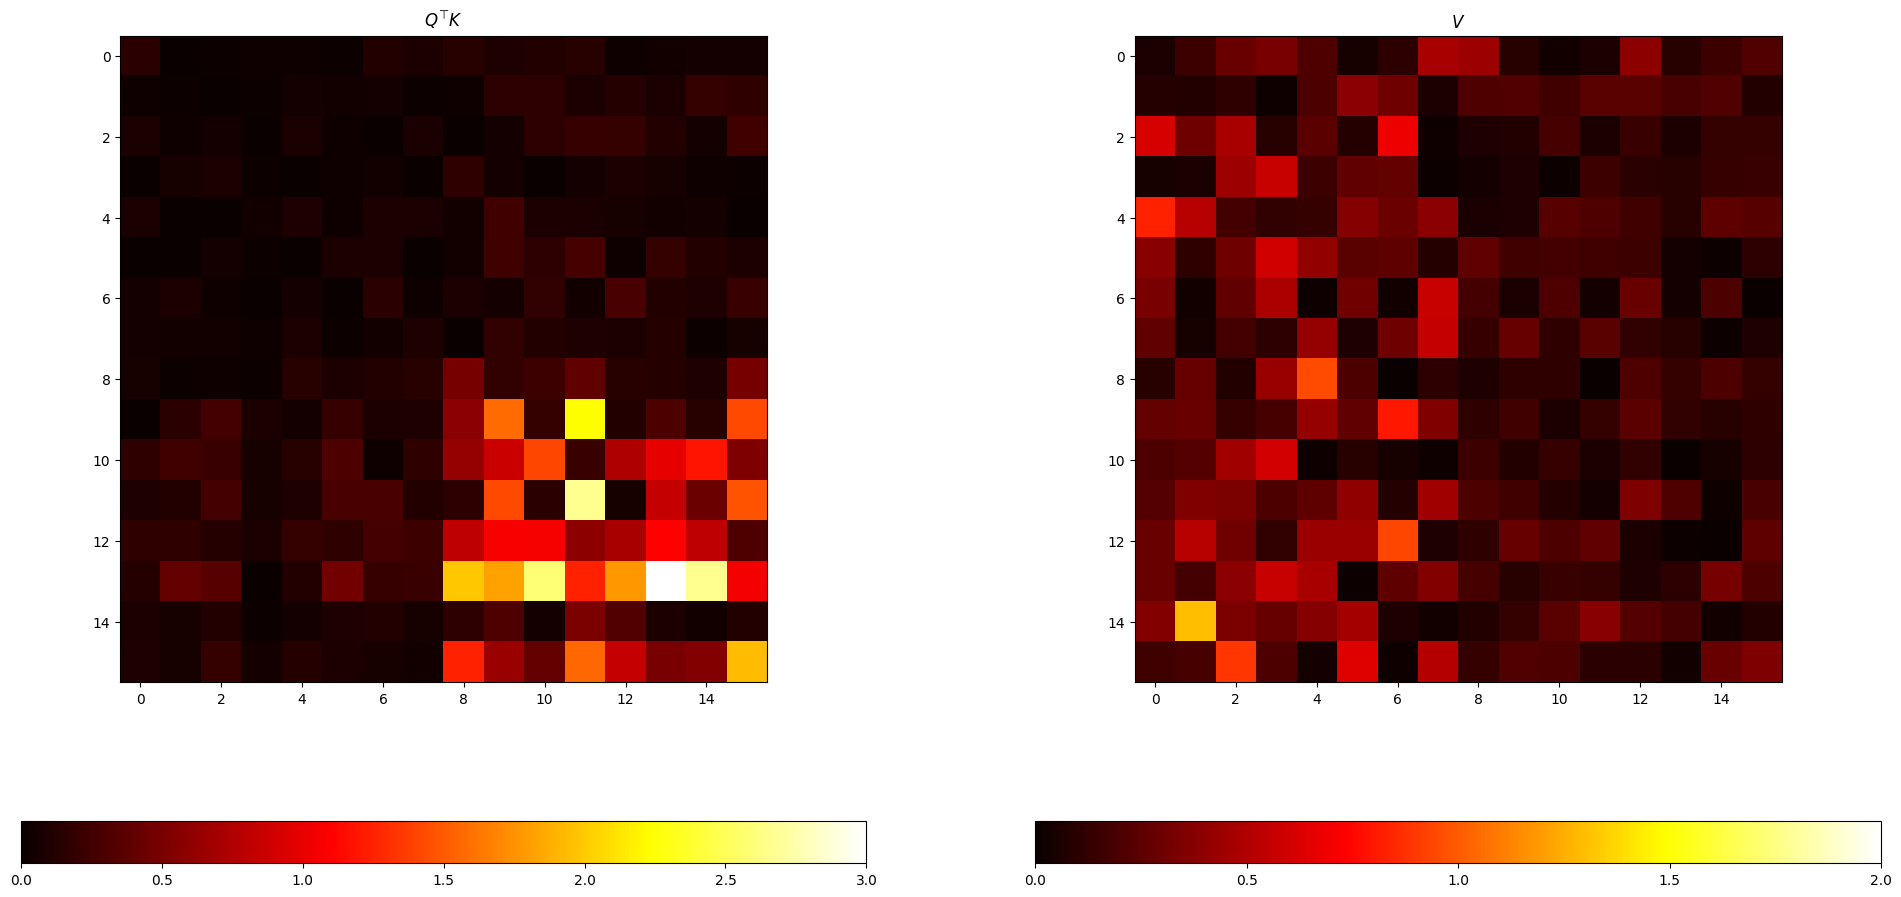

In [56]:
import matplotlib.pyplot as plt
index=5

latent_d=16
Q=model.blocks[index].attn.qkv.state_dict()['weight'][:latent_d].cpu()
K=model.blocks[index].attn.qkv.state_dict()['weight'][latent_d:2*latent_d].cpu()
V=model.blocks[index].attn.qkv.state_dict()['weight'][2*latent_d:3*latent_d].cpu()

QK=torch.abs(Q.T@K)
V=torch.abs(V)
plt.figure(figsize=(24,12))
plt.subplot(1,2,1)
sc1=plt.imshow(QK.cpu(),cmap='hot')
sc1.set_clim(0,3)
plt.colorbar(orientation='horizontal',ticks=([0,0.5,1,1.5,2,2.5,3]) )
plt.title(r"$Q^{\top}K$")
plt.subplot(1,2,2)
sc2=plt.imshow(V,cmap='hot')
sc2.set_clim(0,2)
plt.colorbar(orientation='horizontal',ticks=([0,0.5,1,1.5,2]))
plt.title(r"$V$")

In [81]:
import  matplotlib.pyplot as plt

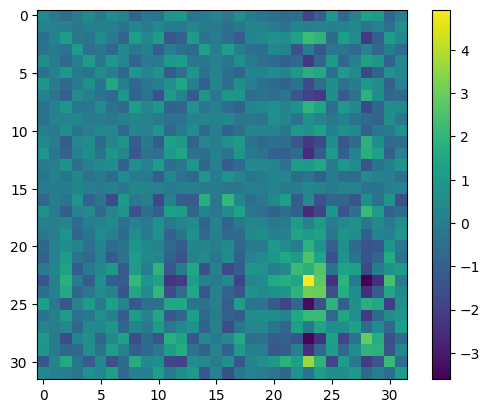

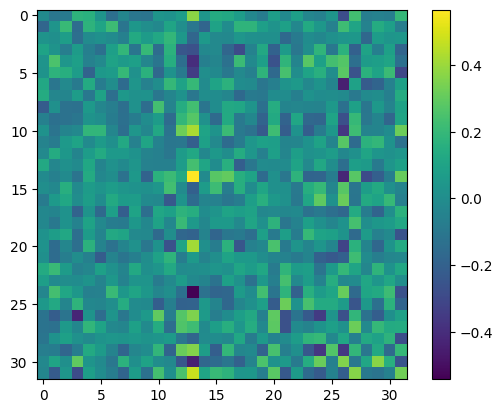

In [21]:
diffusion

In [60]:

sample_args_dict = {
        "model": f"DiT-PD/8_N=128",
        "vae": "mse",
        "seq_length":128,
        "image_size": 8,
        "sample_size":1000,
        "num_classes": 1000,
        "cfg_scale": 0,
        "num_sampling_steps": 1000,
        "seed": 0,
        "ckpt": "./video_results_n=10000_v=2_l=512_N=128_r=0/ep39_0001560.pt",
        "result_path":"video_samples",
        "name":'yokka-cfg0-testQKV2'
        # "ckpt":None
    }

sample_args = ArgsDict(sample_args_dict)
sample_main(sample_args)

ok


RuntimeError: Error(s) in loading state_dict for DiT:
	size mismatch for pos_embed: copying a param with shape torch.Size([1, 128, 32]) from checkpoint, the shape in current model is torch.Size([1, 128, 16]).
	size mismatch for x_embedder.linear.weight: copying a param with shape torch.Size([32, 8]) from checkpoint, the shape in current model is torch.Size([16, 8]).
	size mismatch for x_embedder.linear.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).

## Training DiT

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
from time import time
import os
import argparse
import logging
from copy import deepcopy
from collections import OrderedDict


from diffusers.models import AutoencoderKL

from tqdm import tqdm

os.chdir("./")

logging.basicConfig(filename='training.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


@torch.no_grad()
def update_ema(ema_model, model, decay=0.9999):
    """
    Step the EMA model towards the current model.
    """
    ema_params = OrderedDict(ema_model.named_parameters())
    model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        # TODO: Consider applying only to params that require_grad to avoid small numerical changes of pos_embed
        ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)


def requires_grad(model, flag=True):
    """
    Set requires_grad flag for all parameters in a model.
    """
    for p in model.parameters():
        p.requires_grad = flag


def main(args):
    """
    Trains a new DiT model without using distributed training.
    """
    assert torch.cuda.is_available(), "Training currently requires at least one GPU."

    if not os.path.exists(args.results_dir):
        os.mkdir(args.results_dir)

    # Create model:
    # Note: You need to define DiT_models, create_diffusion, and other required objects
    #       or import them from your implementation.
    model = DiT_models[args.model](
        input_size=args.image_size,
        num_classes=args.num_classes,
        class_dropout_prob=args.class_dropout_prob
    )
    ema = deepcopy(model).cuda()  # Create an EMA of the model for use after training
    requires_grad(ema, False)
    model = model.cuda()
    diffusion = create_diffusion(timestep_respacing="")
    # vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{args.vae}").cuda()

    # Setup optimizer
    opt = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3000, gamma=0.8)
    # Setup data:
    data = np.load('./video_data/'+args.data_file)
    dataset = TensorDataset(torch.from_numpy(data))
    loader = DataLoader(
        dataset,
        batch_size=args.global_batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True
    )

    # Variables for monitoring/logging purposes:
    train_steps = 0
    log_steps = 0
    running_loss = 0
    start_time = time()

    print(f"Training for {args.epochs} epochs...")
    for epoch in range(args.epochs):
        print(f"Beginning epoch {epoch}...")
        for x in tqdm(loader):
            x = x[0].to(torch.float32).cuda()
            y = torch.zeros(x.shape[0], dtype=torch.int).cuda()
            # print('input x shape: ',x.shape)
            # with torch.no_grad():
            #     x = vae.encode(x).latent_dist.sample().mul_(0.18215)
            #     print(x.shape)
            t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],)).cuda()
            model_kwargs = dict(y=y)
            loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
            loss = loss_dict["loss"].mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
            scheduler.step()
            update_ema(ema, model)

            # Log loss values:
            running_loss += loss.item()
            log_steps += 1
            train_steps += 1
            if train_steps % args.log_every == 0:
                torch.cuda.synchronize()
                end_time = time()
                steps_per_sec = log_steps / (end_time - start_time)
                avg_loss = torch.tensor(running_loss / log_steps).cuda()
                logging.info(f'Epoch {epoch}, Step {train_steps}: Loss = {avg_loss}')
                print(f"(step={train_steps:07d}) Train Loss: {avg_loss:.4f}, Train Steps/Sec: {steps_per_sec:.2f}")
                running_loss = 0
                log_steps = 0
                start_time = time()
                
        # Save DiT checkpoint:
        checkpoint = {
                "model": model.state_dict(),
                "ema": ema.state_dict(),
                "opt": opt.state_dict(),
        }
        checkpoint_path = f"{args.results_dir}/ep{epoch}_{train_steps:07d}.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")

    print("Done!")



In [10]:
num_videos=10000
v=2
l_=64
seq_length=32
repeat=0

args_dict = {
                    "nnodes":1,
                    "nproc_per_node":"N",
                    "data_file":f"data_videos_n={num_videos}_v={v}_l={l_}_N={seq_length}_r={repeat}.npy",
                    "results_dir": "./video_results_testQKV1",
                    "model": f"DiT-PD/8_N={seq_length}",
                    "image_size": 8,
                    "num_classes": 1000,
                    "epochs": 20,
                    "global_batch_size": 256,
                    "global_seed": 0,
                    "vae": "ema",
                    "num_workers": 4,
                    "log_every": 100,
                    "ckpt_every": 50000,
                    "class_dropout_prob": 1
                }

args = ArgsDict(args_dict)
main(args)

Training for 20 epochs...
Beginning epoch 0...


100%|██████████| 39/39 [00:03<00:00, 12.57it/s]


Saved checkpoint to ./video_results_testQKV1/ep0_0000039.pt
Beginning epoch 1...


100%|██████████| 39/39 [00:01<00:00, 19.78it/s]


Saved checkpoint to ./video_results_testQKV1/ep1_0000078.pt
Beginning epoch 2...


 64%|██████▍   | 25/39 [00:01<00:00, 23.10it/s]

(step=0000100) Train Loss: 0.3742, Train Steps/Sec: 15.89


100%|██████████| 39/39 [00:01<00:00, 20.20it/s]


Saved checkpoint to ./video_results_testQKV1/ep2_0000117.pt
Beginning epoch 3...


100%|██████████| 39/39 [00:01<00:00, 19.83it/s]


Saved checkpoint to ./video_results_testQKV1/ep3_0000156.pt
Beginning epoch 4...


100%|██████████| 39/39 [00:01<00:00, 20.52it/s]


Saved checkpoint to ./video_results_testQKV1/ep4_0000195.pt
Beginning epoch 5...


 21%|██        | 8/39 [00:00<00:01, 15.78it/s]

(step=0000200) Train Loss: 0.1296, Train Steps/Sec: 18.69


100%|██████████| 39/39 [00:02<00:00, 17.35it/s]


Saved checkpoint to ./video_results_testQKV1/ep5_0000234.pt
Beginning epoch 6...


100%|██████████| 39/39 [00:01<00:00, 20.03it/s]


Saved checkpoint to ./video_results_testQKV1/ep6_0000273.pt
Beginning epoch 7...


 74%|███████▍  | 29/39 [00:01<00:00, 22.62it/s]

(step=0000300) Train Loss: 0.1019, Train Steps/Sec: 18.84


100%|██████████| 39/39 [00:02<00:00, 19.05it/s]


Saved checkpoint to ./video_results_testQKV1/ep7_0000312.pt
Beginning epoch 8...


100%|██████████| 39/39 [00:01<00:00, 19.78it/s]


Saved checkpoint to ./video_results_testQKV1/ep8_0000351.pt
Beginning epoch 9...


100%|██████████| 39/39 [00:01<00:00, 19.58it/s]


Saved checkpoint to ./video_results_testQKV1/ep9_0000390.pt
Beginning epoch 10...


 31%|███       | 12/39 [00:00<00:01, 18.86it/s]

(step=0000400) Train Loss: 0.1002, Train Steps/Sec: 17.65


100%|██████████| 39/39 [00:01<00:00, 19.71it/s]


Saved checkpoint to ./video_results_testQKV1/ep10_0000429.pt
Beginning epoch 11...


100%|██████████| 39/39 [00:02<00:00, 17.51it/s]


Saved checkpoint to ./video_results_testQKV1/ep11_0000468.pt
Beginning epoch 12...


 87%|████████▋ | 34/39 [00:02<00:00, 19.60it/s]

(step=0000500) Train Loss: 0.0980, Train Steps/Sec: 17.93


100%|██████████| 39/39 [00:02<00:00, 16.49it/s]


Saved checkpoint to ./video_results_testQKV1/ep12_0000507.pt
Beginning epoch 13...


100%|██████████| 39/39 [00:02<00:00, 16.81it/s]


Saved checkpoint to ./video_results_testQKV1/ep13_0000546.pt
Beginning epoch 14...


100%|██████████| 39/39 [00:02<00:00, 17.03it/s]


Saved checkpoint to ./video_results_testQKV1/ep14_0000585.pt
Beginning epoch 15...


 46%|████▌     | 18/39 [00:01<00:01, 18.75it/s]

(step=0000600) Train Loss: 0.0957, Train Steps/Sec: 16.12


100%|██████████| 39/39 [00:02<00:00, 17.20it/s]


Saved checkpoint to ./video_results_testQKV1/ep15_0000624.pt
Beginning epoch 16...


100%|██████████| 39/39 [00:02<00:00, 16.49it/s]


Saved checkpoint to ./video_results_testQKV1/ep16_0000663.pt
Beginning epoch 17...


100%|██████████| 39/39 [00:02<00:00, 16.76it/s]

(step=0000700) Train Loss: 0.0962, Train Steps/Sec: 16.87


Saved checkpoint to ./video_results_testQKV1/ep17_0000702.pt
Beginning epoch 18...


100%|██████████| 39/39 [00:02<00:00, 17.02it/s]


Saved checkpoint to ./video_results_testQKV1/ep18_0000741.pt
Beginning epoch 19...


100%|██████████| 39/39 [00:02<00:00, 17.38it/s]

Saved checkpoint to ./video_results_testQKV1/ep19_0000780.pt
Done!


## hihihi

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 1. 加载.npy文件为数据集
data = np.load('./data_videos_100000.npy')

# 2. 创建数据集对象
dataset = TensorDataset(torch.from_numpy(data))


# 3. 调整批量大小
batch_size = 32



In [19]:
# 4. 创建 DataLoader
loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    # sampler=sampler,  # 如果有需要的话，可以使用sampler来自定义数据采样器
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True  # 如果你希望最后一个批次不足batch_size的数据被丢弃，可以设置drop_last=True
)


for batch_idx, data in enumerate(loader):
    print(f"Batch {batch_idx + 1}:")
    # print(data[0].shape)  # 打印每个批次的数据形状
    # print("Target shape:", target.shape)  # 打印每个批次的目标形状

    # 在这里可以添加更多的检查逻辑，比如检查数据的范围、数据类型等

    # 如果你只想检查一部分批次，可以设置一个检查的批次上限，比如检查前5个批次
    if batch_idx >= 1:
        break

NameError: name 'args' is not defined

In [13]:
torch.cuda.empty_cache()

## visualization

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def heat_map(data,title="",savefig=False):
    plt.imshow(data, cmap='viridis',vmin=0,vmax=5)  # 你可以选择不同的颜色映射，如'hot', 'cool', 'jet'等
    plt.colorbar()
    plt.title(title)
    if savefig==False:
        plt.show()
    else:
        plt.savefig("./figs/"+title)

[[ 0.3390308  -0.45496845  5.4594994  ...  0.6157193  -1.1156646
  -0.56972957]
 [-0.3331662  -0.8278341   5.367446   ... -0.2502686  -0.04135247
  -0.14824602]
 [-0.94478756 -1.1334251   5.1832848  ... -1.0653864   0.9624406
   0.23675145]
 ...
 [ 1.725438   -3.2552564   2.350966   ...  0.20411734 -2.2201693
   3.3358045 ]
 [ 1.9297364  -2.5450842   2.50202    ... -0.23764077 -1.7430671
   3.3727434 ]
 [ 2.0494826  -1.822326    2.4775472  ... -0.7060787  -1.1774477
   3.3858528 ]]


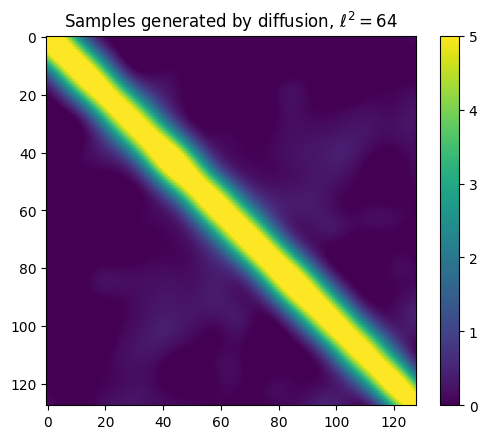

In [34]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

np.random.seed(66)

data_source = "./video_samples/sample_yokka-cfg0-decay64_1000.npy"
# data_source = "/guojiawei1/video_samples/sample_yokka-noema-cfgfixed_1000.npy"
# data_source = "/guojiawei1/video_samples/sample_yokka-2_1000.npy"
# data_source = "/guojiawei1/video_data/data_videos_100000_cpseed66_ksqr_l8192.npy"
# 1. 加载.npy文件为数据集
data = np.load(data_source)

N, T, D=data.shape

# arr =data
# mean = arr.mean(axis=(1, 2), keepdims=True)
# vari = arr.var(axis=(1, 2), keepdims=True)
# # 避免除以零，可以给方差加一个小的常数，例如1e-8
# std = np.sqrt(vari + 1e-8)
# # 对每个 (T, D) 子数组进行正规化
# normalized_arr = (arr - mean) / std
# data = normalized_arr

print(data[1])

x = data.reshape(N,-1) ## (N, T*D)

x_mean = x.mean(axis=0)

x_diff =x-x_mean



var_simple=np.einsum("na,nb->nab",data[:,:,0]-np.mean(data[:,:,0],axis=0),data[:,:,0]-np.mean(data[:,:,0],axis=0)).mean(axis=0)

# max = np.max(np.abs(var[:8][:8]))
# p = var[:8,:8]/max
# heat_map(var)


sigma = np.load('./cpseed66.npy')

heat_map(var_simple,title="Samples generated by diffusion, "+r"$\ell^2=64$",savefig=True)
# i,j=0,1
# heat_map(sigma)
# heat_map(var[8*i:8*(i+1),8*j:8*(j+1)])

# a=0.1
# new_matrix = np.abs(cor) > a
# # 将布尔值数组转换为整数数组（True 转换为 1，False 转换为 0）
# new_matrix = new_matrix.astype(int)
# heat_map(new_matrix)



In [35]:
# data_source = "/guojiawei1/video_samples/sample_yokka-noema-cfgfixed_1000.npy"
#data_source = "/guojiawei1/video_samples/sample_yokka-cfg0_10.npy"
data_source = "./video_data/data_videos_100000.npy"
# 1. 加载.npy文件为数据集# plt.hist(data.reshape(-1),bins=50)
sigma = np.load('./cpseed66.npy')
print(sigma)
data = np.load(data_source)



[[ 5.99468524  2.7198868  -0.57810818  2.30005148 -2.41174756  3.05909688
  -5.34447446 -0.85877692]
 [ 2.7198868  12.42413287  0.59547616 -1.44926262 -4.93444453  6.54279729
  -1.37216244 -3.67312977]
 [-0.57810818  0.59547616 17.37082459 -3.28682119 -2.11180831 -1.15217731
   4.05443355  2.67162655]
 [ 2.30005148 -1.44926262 -3.28682119  7.25528919  1.29111283 -2.41329307
  -2.06981072 -3.9014807 ]
 [-2.41174756 -4.93444453 -2.11180831  1.29111283  8.14584652  0.88960593
  -2.18398531  0.26088043]
 [ 3.05909688  6.54279729 -1.15217731 -2.41329307  0.88960593 12.7460604
  -8.82650516  0.15984501]
 [-5.34447446 -1.37216244  4.05443355 -2.06981072 -2.18398531 -8.82650516
  10.62747113 -0.14100758]
 [-0.85877692 -3.67312977  2.67162655 -3.9014807   0.26088043  0.15984501
  -0.14100758  7.2134552 ]]


In [36]:
var_simple=np.einsum("na,nb->nab",data[:,:,0]-np.mean(data[:,:,0],axis=0),data[:,:,0]-np.mean(data[:,:,0],axis=0)).mean(axis=0)

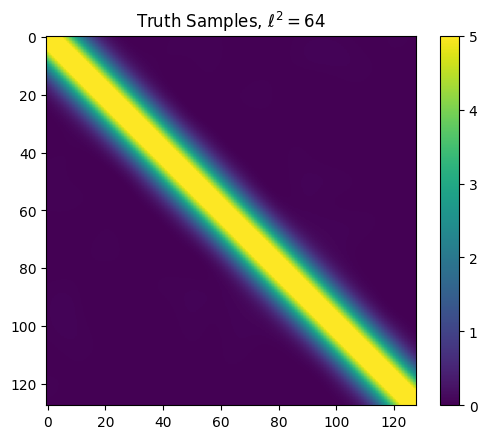

In [37]:
heat_map(var_simple,title="Truth Samples, "+r"$\ell^2=64$",savefig=True)

In [33]:
\np.var(data[:,0,0])

5.93204851786183